# Real and Fake news analysis

In this analysis, we proceed to analyse the real and fake news dataset without the authors approach, but with standard NLP techniques (tf-idf + MLP, RNN (LSTM)) . 
We will see and compare the differences between the results we had for the previous analysis

**Note:** This code was run on google colab

## Imports and Configurations

In [2]:
#installing tweet-preprocessor used to preprocess the tweets
!pip install tweet-preprocessor

In [3]:
!pip install wordcloud

In [5]:
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import seaborn as sns
import string
import preprocessor as p
from wordcloud import WordCloud, STOPWORDS
import bs4 as bs4 
import re
from metrics import *
import scipy 

In [6]:
#remove warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

In [8]:
import nltk
from textblob import TextBlob
nltk.download('words')
from nltk.corpus import words

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.metrics import BinaryAccuracy
from keras import regularizers
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [10]:
#use GPU if available
import torch

if torch.cuda.is_available():
    torch.device("cuda")
    print("gpu")
else: 
    print("cpu")

gpu


## Dataset loading and cleaning

In [22]:
#set the data folder name
DATA_FOLDER = 'data_news'

#set the path for the news datasets using os.path.join to gurantee that it work on the different operating systems
True_news_PATH= os.path.join(DATA_FOLDER, "True.csv")
FAKE_news_PATH= os.path.join(DATA_FOLDER, "Fake.csv")


#read the True news dataset
True_dataset = pd.read_csv(True_news_PATH)

#add a new column label that we to one for the True news
True_dataset['label'] = np.ones(len(True_dataset))

#True news start with the company's name(Reuters) and locaion of news thus we remove them
True_dataset["text"] = True_dataset["text"].apply(lambda x : x.split('-', 1)[1] if '-' in x else x)


#read the Fake news dataset
Fake_dataset = pd.read_csv(FAKE_news_PATH)

#add a new column label that we to zero for the Fake news
Fake_dataset['label'] = np.zeros(len(Fake_dataset))

#merge the True and Fake news 
dataset = pd.concat([True_dataset, Fake_dataset]).reset_index(drop=True)
dataset.sample(15)

,title,text,subject,date,label
9780,Republican presidential candidate Cruz to make...,Republican presidential candidate Ted Cruz sa...,politicsNews,"April 27, 2016",1.0
15843,Kurds offer joint border deployment as Iraq th...,Iraq s Kurdish region said on Thursday it had...,worldnews,"November 2, 2017",1.0
17261,U.S.-backed Syrian militias raise flag in Raqq...,U.S.-backed Syrian Democratic Forces (SDF) ra...,worldnews,"October 17, 2017",1.0
37717,OUTRAGE! HOW REFUGEE RESETTLEMENT Is Using Uni...,Admitting Somalis who d been settled for year...,Government News,"Dec 9, 2016",0.0
21542,Multiple Witnesses Confirm: The Pee Pee Tapes...,"Remember the fabled pee pee tapes? Well, it se...",News,"November 7, 2017",0.0
10754,Oil industry bet big on Jeb Bush for president...,U.S. oil and gas executives bet big on 2016 R...,politicsNews,"February 19, 2016",1.0
20644,Malaysia ready to provide temporary shelter fo...,Malaysia s coast guard will not turn away Roh...,worldnews,"September 8, 2017",1.0
41976,SEX ROULETTE PARTIES On The Rise…One Person Is...,Culture rot The health professionals who will ...,left-news,"May 17, 2016",0.0
34393,MN SOMALI Residents Comment On MUSLIM Who Stab...,He was such a nice boy!Where have we heard thi...,politics,"Sep 18, 2016",0.0
22776,Watch Trump Shove Foreign Leader Out Of The W...,Donald Trump met with the other members of NAT...,News,"May 25, 2017",0.0


Here we proceed to clean even further the data set:
The texts sometimes contain (expescially the fake ones) some HTML skeletons, some of the texts simply contain a URL.
All of the other text as well (if they come from tweeter) contain a lot of # or @ characters, aside from the normal punctuation characters. These might disrupt our analysis and add a lot of noise to the training process. Thus we get rid of them. 

In [23]:
#print an entry before preprocessing to compare later
dataset['text'].iloc[0]

' The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support education, scientific resear

In [12]:
# Characters to be handled by p.clean
twitter_replacables = "#@" 

# Characters to be replaced by empty string 
empty_replacables = "".join([i for i in string.punctuation if not (i in twitter_replacables)])+"”" 

#removal of HTML pages skeletons and replace empty strings with the punctuation and finally remove of URLs, Mentions
dataset["text"] = dataset["text"].apply(lambda text: bs4.BeautifulSoup(text,"html.parser").get_text()).apply(lambda s: s.translate(str.maketrans('', '', empty_replacables))).apply(p.clean) 

In [24]:
dataset["text"] = dataset["text"].apply(lambda text: bs4.BeautifulSoup(text,"html.parser").get_text()) \
                  .apply(lambda s: s.translate(str.maketrans('', '', empty_replacables))) \
                  .apply(p.clean)

In [25]:
# remove entries with empty strings
dataset = dataset[dataset["text"].apply(len)>0].reset_index(drop=True)

In [26]:
#print an entry after preprocessing
dataset['text'].iloc[0]

'The head of a conservative Republican faction in the US Congress who voted this month for a huge expansion of the national debt to pay for tax cuts called himself a fiscal conservative on Sunday and urged budget restraint in In keeping with a sharp pivot under way among Republicans US Representative Mark Meadows speaking on CBS Face the Nation drew a hard line on federal spending which lawmakers are bracing to do battle over in January When they return from the holidays on Wednesday lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues such as immigration policy even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress President Donald Trump and his Republicans want a big budget increase in military spending while Democrats also want proportional increases for nondefense discretionary spending on programs that support education scientific research infrastructure public health 

## Visualization of the dataset

After having cleaned the dataset, we proceed to visualize its main compnenents to understand the dominant topics and features that appear recurrently. 

In [38]:
#method to create a wordcloud and plot it to see the most common words in each dataset
def create_wordcloud(text, title):
    """
    function that plots a word cloud given a text and a title. 
    
    args: 
    text a string with of the text we want a word cloud of. 
    title a string representing the title of the plot
    """
    wordcloud = WordCloud(max_font_size=30, max_words=200, background_color="white",stopwords = set(STOPWORDS)).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title,  fontsize=20)
    plt.show()

In [39]:
#get the Fake news texts
Fake = dataset.loc[dataset['label'] == 0,'text']

#get the True news texts
Real = dataset.loc[dataset['label'] == 1,'text']

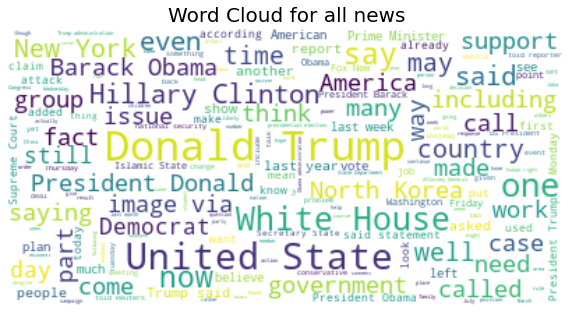

In [40]:
#get the wordcloud for the Fake news
create_wordcloud(" ".join(text for text in dataset['text']), "Word Cloud for all news")

In [41]:
def get_top_text_ngrams(corpus, n, g):
    """
    method to get the top n n-grams of sizes 1,2, and 3 for a given corpus
    
    args:
    corpus: list of words in order
    n: the number of n-grams to be returned
    g: the n-gram size
    
    returns:
    A list of the top n n-grams
    """
    vec = CountVectorizer(ngram_range=(g, g), stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


In [42]:
def make_ngram_plot (d, nb, title_):
    """
    method to to plot the top 1-gram, 2-grams and 3-grams
    
    args:
    corpus: list of words in order
    n: the number of n-grams to be returned
    g: the n-gram size
    
    returns:
    A list of the top n n-grams
    """
    fig, axes = plt.subplots(1,3,figsize=(11,3))
    
    for x in range(1, 4):
        most_common_uni = get_top_text_ngrams(d, nb, x)
        most_common_uni = dict(most_common_uni)
        sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()), ax=axes[x-1])
        axes[x-1].set_xlabel('Occurences')
        axes[x-1].set_title('Most common words in the n=' + str(x) + " bag.")
    
    fig.suptitle(title_, y=0)
    plt.tight_layout()
    plt.show()

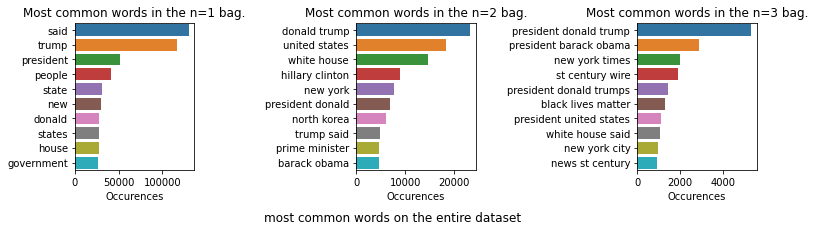

In [43]:
#plot the top ngrams for the Real dataset
make_ngram_plot(dataset['text'], 10, "most common words on the entire dataset")

We can see through these plots that 'said' is one of the most common words in both datasets, thus the dataset is comprised of a lot of quotes or hearsay about various eminent political figures (Trump, Obama, Clinton, rex tillerson ...) and their political parties (Republican or Democrat). The dataset also quotes various infamous news sources (Fox news, New York Times, ...). We see also a lot of recently trending topics in the world like "Black lives matter". Central hubs of power are (New York , North Korea, the White House) are also mentioned all the way throughout the news. Thus, the lingo is mostly based on US political news (internal or external).

After these visualizations, we developed two models to classify our data. The first is an MLP model combined with TF-IDF while the second is a more complex one, an RNN model. We describe in the following sections these two models and their results.

## Multilayer Perceptron and Tf-idf analysis

The objective in this section is to be able to accurately predict what is fake news and what isn't. 
However, even after cleaning our dataset, we still need to map our documents to a adequatley representative vector space, so that we can accurately make predictions. 
We opt now for tf-idf vectorizer, with as features the most common words (at least 0.01% in document frequency).
We scale the vectors at the end with an l2 norm scaling.

In [43]:
#we create a TF-IDF vectorizer to create TF-IDF representations for the data points in our datasets
#we lowercase the words, we remove the english stopwords, we use the L2 norm, we keep only words with minimum frequency of
#0.01. we use a 'token_pattern' to keep only engligh characters and remove all the rest
vectorizer = TfidfVectorizer(lowercase =True, stop_words='english', norm='l2', token_pattern =r'[a-zA-Z]+', min_df=0.01)

#Transform the text sparse matrix to a normalized tf or tf-idf representation
X = vectorizer.fit_transform(dataset["text"])

print("vectorized dataset shape:", X.shape)


vectorized dataset shape: (44267, 2863)


In [44]:
# We take a look at the features
print("vectorizer feature names: ", vectorizer.get_feature_names())

vectorizer feature names:  ['abc', 'ability', 'able', 'abortion', 'abroad', 'absolute', 'absolutely', 'abuse', 'accept', 'accepted', 'access', 'accord', 'according', 'account', 'accountable', 'accounts', 'accusations', 'accuse', 'accused', 'accusing', 'achieve', 'acknowledged', 'act', 'acted', 'acting', 'action', 'actions', 'active', 'actively', 'activist', 'activists', 'activities', 'activity', 'acts', 'actual', 'actually', 'ad', 'adam', 'add', 'added', 'adding', 'addition', 'additional', 'address', 'addressed', 'addressing', 'administration', 'administrations', 'admit', 'admitted', 'adopted', 'advance', 'advanced', 'advantage', 'advice', 'adviser', 'advisers', 'advisor', 'advocacy', 'advocate', 'advocates', 'affairs', 'affect', 'affected', 'afford', 'affordable', 'afghanistan', 'afraid', 'africa', 'african', 'africanamerican', 'afternoon', 'age', 'agencies', 'agency', 'agenda', 'agent', 'agents', 'aggressive', 'ago', 'agree', 'agreed', 'agreement', 'agreements', 'ahead', 'aid', 'aide

Text(0.5, 1.0, 'Ditribution of the standard deviations')

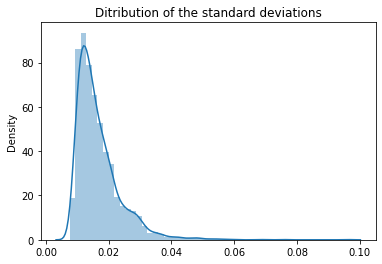

In [45]:

def std (colindex):
    """ 
    A function that shows the standard deviation of a given column of X
    
    args: 
    The index of the column we want 
    
    returns: 
    The standard deviation of that column
    """
    return np.std(X.getcol(colindex).toarray())


# We plot the distribution of the stds to see approxitavely how much variance each feature explains.
std_X = [std(i) for i in range(X.shape[1])]

sns.distplot(std_X)
plt.title("Ditribution of the standard deviations")

In [46]:
#split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, dataset["label"])

#define a Multi-layer Perceptron classifier
clf = MLPClassifier([300, 100, 50], verbose=True, early_stopping=True, alpha=0.001)

#train the classifier on the train sets
clf.fit(X_train, y_train)

Iteration 1, loss = 0.14256419
Validation score: 0.982831
Iteration 2, loss = 0.02697871
Validation score: 0.985542
Iteration 3, loss = 0.01353430
Validation score: 0.985241
Iteration 4, loss = 0.00873961
Validation score: 0.986145
Iteration 5, loss = 0.00777723
Validation score: 0.986446
Iteration 6, loss = 0.00545530
Validation score: 0.985843
Iteration 7, loss = 0.00492089
Validation score: 0.986747
Iteration 8, loss = 0.00401049
Validation score: 0.986747
Iteration 9, loss = 0.00364257
Validation score: 0.988855
Iteration 10, loss = 0.00328230
Validation score: 0.987651
Iteration 11, loss = 0.00312713
Validation score: 0.987349
Iteration 12, loss = 0.00299611
Validation score: 0.987048
Iteration 13, loss = 0.00286650
Validation score: 0.987651
Iteration 14, loss = 0.00273783
Validation score: 0.987651
Iteration 15, loss = 0.00260997
Validation score: 0.987651
Iteration 16, loss = 0.00248309
Validation score: 0.987651
Iteration 17, loss = 0.00235752
Validation score: 0.988253
Iterat

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=[300, 100, 50], learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

In [47]:
print("accuracy of the Multi-layer Perceptron classifier:" , clf.score(X_test, y_test))

accuracy of the Multi-layer Perceptron classifier: 0.9862654739315081


Text(0.5, 1.0, '2-class Precision-Recall curve')

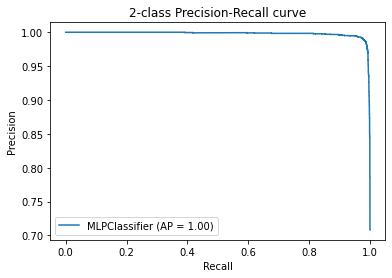

In [48]:
#get the predictions on the test set
y_score = clf.predict(X_test)


average_precision = average_precision_score(y_test, y_score)

#get the precision-recall curve
disp = plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve')

We see that the model performs extremely well as we got an average precision of 100% and it has an almost perfect AUC (Area Under the Curve).

## Classifier analysis 

Let us now attempt to analyze how our Multi-Layer Perceptron classifies the news:

In [49]:
#get the prediction probabilities for every word 
result = clf.predict_proba(np.eye(X_train.shape[1]))[:, 1]

# we create a dataframe to associate 
tbp = pd.DataFrame({"words": vectorizer.get_feature_names(), "probability": result}).sort_values("probability", ascending=True)
tbp.sample(10)

,words,probability
22,act,0.006213
918,expanded,0.969161
2736,violent,0.000234
1105,girl,0.000038
253,begin,0.000093
2113,relations,0.000133
160,arabia,0.001874
897,europe,0.000004
499,committed,0.000337
599,countrys,0.998851


In [50]:
#get the english dictionary words
english_dictionnary = set(words.words())



def measure_subjectivity_from_words (indicator_words, title = "", plot=True): 
    """
    Method to measure subjectivity from a set of words, using TextBlob that finds words
    for which we have a subjectivity measure. 
    In textblob the overall subjectivity measure is the average of this atomic measures
    thus in this case we levrage these atomic measure instead of the average. 
    
    args: 
    indicator_words is the list of words we want to measure the subjectivty.
    title is the title of the plt 
    """
    bv = [x[2] for x in TextBlob(' '.join(indicator_words)).sentiment_assessments.assessments]
    if plot:
        sns.displot(bv)
        plt.title("Subjectivity distribution for " + title + " news") 
        print("mean is: ", np.mean(bv), "and std is: ", np.std(bv))
    return bv

  

mean is:  0.48160522273425505 and std is:  0.3557371000922685


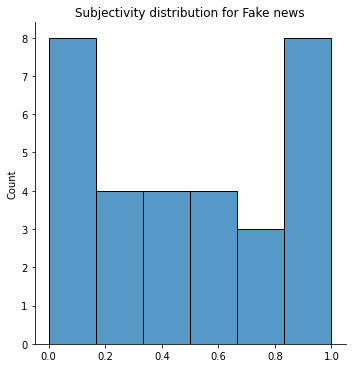

In [75]:
# We select the top 200 words that have the highest probability of being classified as fake
Fake_indicators = tbp["words"].iloc[:200].values

# We keep the words that are only in the english dictionnary to get a reasonable measure on the subjectivity
Fake_indicator_words = list(filter(lambda _: _ in english_dictionnary, Fake_indicators))

# We measure the subjectivity of these indicators
false_subjectivity = measure_subjectivity_from_words(Fake_indicator_words, 'Fake')


mean is:  0.2223809523809524 and std is:  0.13324274133292902


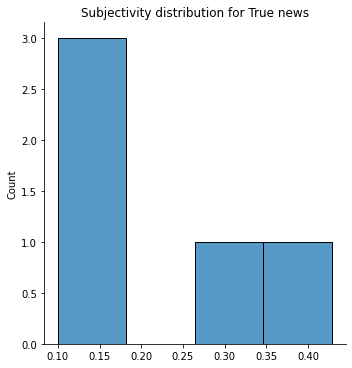

In [76]:
# We select the top 200 words that have the hightest probability of being classified as real
truth_indicators = tbp["words"].iloc[-200:].values

# We keep the words that are only in the english dictionnary to get a reasonable measure on the subjectivity
truth_indicator_words = list(filter(lambda _: _ in english_dictionnary, truth_indicators))

# We measure the subjectivity of these indicators
true_subjectivity = measure_subjectivity_from_words(truth_indicator_words, 'True')

We can clearly see that the distributions are not normal. 
Thus, we perform a Mann Whitney hypothesis test:

In [77]:
scipy.stats.mannwhitneyu(true_subjectivity, false_subjectivity)

MannwhitneyuResult(statistic=50.5, pvalue=0.11195715778222837)

The p-value is large thus we cannot conclude anything about a varriation of subjectivity between the words used for classification for the MLP.

Text(0.5, 1.0, 'Words the MLP uses to detect with high probability Real News')

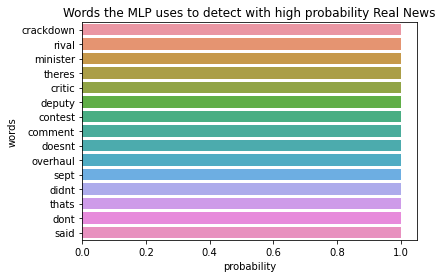

In [53]:
#set the colors
sns.set_color_codes("pastel")

#get the words that have the heighst probabilities of being correctly classified from the True news
plt_data_True = tbp[tbp["words"].isin(english_dictionnary)].iloc[-15:]

#plots these words
sns.barplot(x="probability", y="words", data=plt_data_True)

#set title
plt.title("Words the MLP uses to detect with high probability Real News")


Text(0.5, 1.0, 'Words the MLP uses to detect with high probability Fake News')

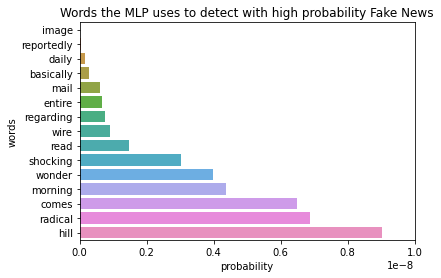

In [67]:
#get the words that have the heighst probabilities of being correctly classified from the Fake news
plt_data_fake= tbp[(tbp["words"].isin(english_dictionnary)) & (tbp["words"].str.len() > 3)].iloc[:15]

#plots these words
sns.barplot(x="probability", y="words", data=plt_data_fake)

plt.xlim(0, 10**-8)
#set titles
plt.title("Words the MLP uses to detect with high probability Fake News")

In [55]:
#we test the MLP model on a Fake sentence that contains two of the words that the MLP uses to detect with a high probabilty Real news
#which are 'said' and 'deputy'
print("probability of classifying the sentence as true is: ", clf.predict_proba(vectorizer.transform(["The deputy said that the WAP group is the best"]))[0][1])

probability of classifying the sentence as true is:  0.9999736807309447


The model has a strong bias towards certain words and thus can be easily tricked it you take it out of context

## Rnn analysis

Some words often come in pairs, like nice and easy or pros and cons. So the co-occurrence of words in a corpus can teach us something about its meaning.
Sometimes, it means they are similar or sometimes it means they are opposite.
The point from embeddings is it to create a vector such as: if two words are similar, they should have similar values in this projected vector space.   

In our case, we use GloVe, which is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase very powerful linear substructures of the word vector space.   
More precisely, we use pre-trained word vectors from twitter with 2B tweets, 27B tokens, 1.2M vocab, uncased. 
We opt for 50 dimension version (as it is enough for our project).

In [29]:
def preprocess_embeddings(embeddings_path, word_index, max_words=20000, embedding_dim=50):
    """
    A function to set the embeddings weights from the embedding file.
    
    args: 
    
    embeddings path: a string describing the path to find the embeddings file.
    word_index: a mapping between text and numbers.
    """
    
    embeddings_idx = {}
    with open(embeddings_path) as embeddings_file:
      for row in embeddings_file:
          split_row = row.split()
          word = split_row[0]
          values = np.asarray(split_row[1:],dtype='float32')
          embeddings_idx[word] = values
    print(str(len(embeddings_idx)) + " words detected.")
    embeddings_mat = np.zeros((max_words, embedding_dim))
    for word, idx in word_index.items():
        if (idx < max_words):
            embedding_vector = embeddings_idx.get(word)
            if embedding_vector is not None:
                embeddings_mat[idx] = embedding_vector
    
    return embeddings_mat


In [32]:
# We instantiate a Tokenizer from keras.
tokenizer = Tokenizer(num_words=20000, lower=True, split=' ')

# We fit the Tokenizer on all of the data from the dataset.
tokenizer.fit_on_texts(dataset["text"])

# We create padded sequences out the tokenized data.
padded = pad_sequences(tokenizer.texts_to_sequences(dataset["text"]), maxlen = 270, padding='post', truncating='post')

# We seperate the data into a training set and a test set
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(padded, dataset["label"], test_size=0.1)


# We get the embeddings weights
embeddings_weights = preprocess_embeddings("glove.twitter.27B.50d.txt", tokenizer.word_index)

print("done preprocessing embeddings")

print(X_train_rnn.shape)

# We declare the model 
model = Sequential()

# We add an embeddings layer and we set its weights to the embeddings weights. 
model.add(Embedding(20000,50,input_length = 270))
model.layers[0].set_weights([embeddings_weights])
model.layers[0].trainable = False

# We add a bidirectional LSTM layer 
model.add(Bidirectional(LSTM(64) , input_shape=padded.shape[1:]))

# We add a dense layer 
model.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))

# We add a dropout layer 
model.add(Dropout(0.2))

# We add an ouput layer 
model.add(Dense(1, activation="sigmoid", kernel_regularizer='l2'))

# We compile the model with the metrics that we need
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=[BinaryAccuracy(threshold=0.5), f1_m, precision_m, recall_m])

# We print the model's summary
model.summary()

1193514 words detected.
done preprocessing embeddings
(39840, 270)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 270, 50)           1000000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               58880     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 1,067,201
Trainable params: 67,201
Non-trainable params: 1,000,000
_________________________________________________________________


In [33]:
#set the callbacks for the model 

#Stop training when the 'binary_accuracy' has stopped improving for 5 epochs.
early_exit = EarlyStopping(monitor='val_binary_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)

#Reduce learning rate when the loss has stopped improving for 5 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min')

In [34]:
#train the model
h = model.fit(X_train_rnn, y_train_rnn, validation_split=0.1, epochs=50, callbacks=[early_exit, reduce_lr])

Epoch 1/50
1121/1121 [==============================] - 30s 24ms/step - loss: 0.3001 - binary_accuracy: 0.8880 - f1_m: 0.8720 - precision_m: 0.8832 - recall_m: 0.8763 - val_loss: 0.2318 - val_binary_accuracy: 0.9137 - val_f1_m: 0.9144 - val_precision_m: 0.8516 - val_recall_m: 0.9921
Epoch 2/50
1121/1121 [==============================] - 26s 23ms/step - loss: 0.1134 - binary_accuracy: 0.9664 - f1_m: 0.9646 - precision_m: 0.9639 - recall_m: 0.9682 - val_loss: 0.0876 - val_binary_accuracy: 0.9744 - val_f1_m: 0.9731 - val_precision_m: 0.9675 - val_recall_m: 0.9807
Epoch 3/50
1121/1121 [==============================] - 26s 23ms/step - loss: 0.0779 - binary_accuracy: 0.9778 - f1_m: 0.9762 - precision_m: 0.9760 - recall_m: 0.9782 - val_loss: 0.0846 - val_binary_accuracy: 0.9724 - val_f1_m: 0.9699 - val_precision_m: 0.9849 - val_recall_m: 0.9574
Epoch 4/50
1121/1121 [==============================] - 26s 23ms/step - loss: 0.0613 - binary_accuracy: 0.9827 - f1_m: 0.9815 - precision_m: 0.9832 

In [35]:
#save the trained model
model.save("rnn_twitter")

INFO:tensorflow:Assets written to: rnn_twitter/assets


INFO:tensorflow:Assets written to: rnn_twitter/assets


In [36]:
#evaluate the model on the test set
model.evaluate(X_test_rnn, y_test_rnn)

139/139 [==============================] - 2s 13ms/step - loss: 0.0331 - binary_accuracy: 0.9919 - f1_m: 0.9915 - precision_m: 0.9947 - recall_m: 0.9889


[0.03312878683209419,
 0.9918680787086487,
 0.9915344715118408,
 0.9947091341018677,
 0.9889072179794312]

Text(0.5, 1.0, 'metrics per epoch')

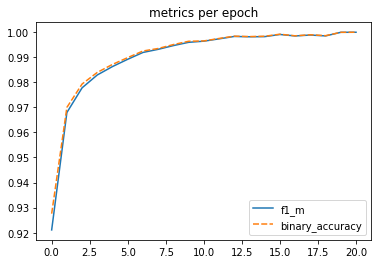

In [38]:
#put their values in a dtaframe
values = pd.DataFrame(h.history)[["f1_m", "binary_accuracy"]]
sns.lineplot(data=values)
plt.title("metrics per epoch")

In [39]:
#we test the RNN model on a Fake sentence that contains two of the words that the MLP uses to detect with a high probabilty Real news
#which are 'said' and 'deputy'
sad_us_rnn = pad_sequences(tokenizer.texts_to_sequences(["The deputy said that the WAP group is the best"]), maxlen = 270, padding='post', truncating='post')

In [41]:
print("probability of classifying the sentence as true is: ", model.predict(sad_us_rnn)[0][0])

probability of classifying the sentence as true is:  0.0012544087


The model is more robust introduced by the words that have high probability of being classified True